# Train-CapsNet

This notebook produces and saves the weights of a Capsule Network trained on MNIST and CIFAR10

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import optim

from datasets import get_mnist_dataset, get_cifar10_dataset, get_data_loader
from utils import *

from models import *

## MNIST

Roughly comparable results to those reported in the paper. Longer training may improve accuracy.

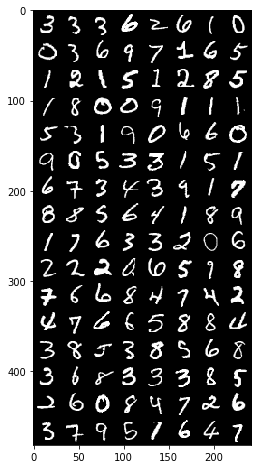

In [3]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [4]:
network = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.005)
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True)

6804224
8215568


In [5]:
MODEL_PATH = 'weights/capsnet_mnist.pth.tar'

In [6]:
caps_trainer.run(epochs=10)
caps_trainer.save_checkpoint(MODEL_PATH)

[*] Training for 10 epochs
[*] Epoch 1, TrnLoss: 87.125, TrnAcc: 0.943, TstLoss: 75.950, TstAcc: 0.984
[*] Epoch 2, TrnLoss: 74.535, TrnAcc: 0.985, TstLoss: 71.671, TstAcc: 0.988
[*] Epoch 3, TrnLoss: 71.293, TrnAcc: 0.990, TstLoss: 69.411, TstAcc: 0.989
[*] Epoch 4, TrnLoss: 69.317, TrnAcc: 0.992, TstLoss: 67.928, TstAcc: 0.991
[*] Epoch 5, TrnLoss: 68.031, TrnAcc: 0.994, TstLoss: 67.007, TstAcc: 0.992
[*] Epoch 6, TrnLoss: 67.133, TrnAcc: 0.996, TstLoss: 66.293, TstAcc: 0.992
[*] Epoch 7, TrnLoss: 66.433, TrnAcc: 0.996, TstLoss: 65.783, TstAcc: 0.992
[*] Epoch 8, TrnLoss: 65.855, TrnAcc: 0.997, TstLoss: 65.302, TstAcc: 0.993
[*] Epoch 9, TrnLoss: 65.366, TrnAcc: 0.997, TstLoss: 64.935, TstAcc: 0.992
[*] Epoch 10, TrnLoss: 64.927, TrnAcc: 0.998, TstLoss: 64.553, TstAcc: 0.993


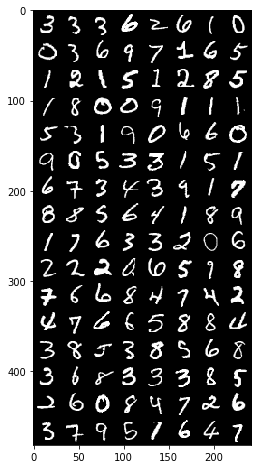

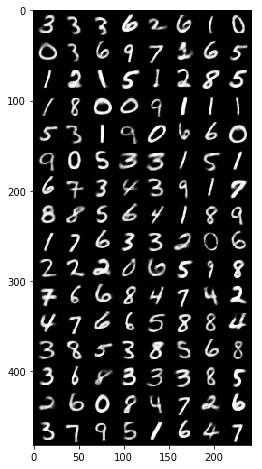

In [7]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data)

## CIFAR10

With a single model, final test accuracy is around 65%. Not quite the results seen in the paper. Other capsnet repositories have similar results.

Given that the vector output of the final capsule layer has dimensionality only 16, the blurriness of the reconstructions is unsurprising. In my experiments, increasing this to 32 resulted in significantly worse accuracy.

Files already downloaded and verified
Files already downloaded and verified


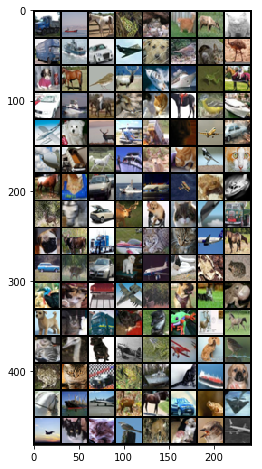

In [8]:
trainset, testset = get_cifar10_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [11]:
network = CapsuleNetwork(img_colors=3, p_caps=64).cuda()
decoder = CapsuleDecoder(img_colors=3, reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.001)
caps_optimizer = optim.Adam(caps_model.parameters(), lr=5e-3)
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)

13628928
16647472


In [12]:
MODEL_PATH = 'weights/capsnet_cifar.pth.tar'

In [13]:
caps_trainer.load_checkpoint(MODEL_PATH)

In [32]:
# this had already been trained for ~15 epochs before this point.
caps_trainer.run(epochs=20)
caps_trainer.save_checkpoint(MODEL_PATH)

[*] Training for 20 epochs
[*] Batch 0, Loss: 73.868, Acc: 0.703
[*] Batch 50, Loss: 73.827, Acc: 0.711
[*] Batch 100, Loss: 72.808, Acc: 0.672
[*] Batch 150, Loss: 73.752, Acc: 0.695
[*] Batch 200, Loss: 73.643, Acc: 0.664
[*] Batch 250, Loss: 74.574, Acc: 0.625
[*] Batch 300, Loss: 73.144, Acc: 0.680
[*] Batch 350, Loss: 74.233, Acc: 0.688
[*] Batch 0, Loss: 75.343, Acc: 0.617
[*] Batch 50, Loss: 75.028, Acc: 0.594
[*] Epoch 1, TrnLoss: 74.182, TrnAcc: 0.642, TstLoss: 74.301, TstAcc: 0.611
[*] Batch 0, Loss: 75.014, Acc: 0.602
[*] Batch 50, Loss: 72.885, Acc: 0.703
[*] Batch 100, Loss: 75.068, Acc: 0.656
[*] Batch 150, Loss: 75.154, Acc: 0.633
[*] Batch 200, Loss: 73.746, Acc: 0.672
[*] Batch 250, Loss: 73.681, Acc: 0.695
[*] Batch 300, Loss: 73.161, Acc: 0.664
[*] Batch 350, Loss: 72.669, Acc: 0.695
[*] Batch 0, Loss: 74.151, Acc: 0.680
[*] Batch 50, Loss: 74.922, Acc: 0.586
[*] Epoch 2, TrnLoss: 74.068, TrnAcc: 0.648, TstLoss: 73.661, TstAcc: 0.635
[*] Batch 0, Loss: 74.505, Acc: 0

KeyboardInterrupt: 

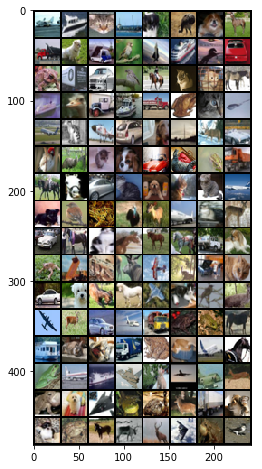

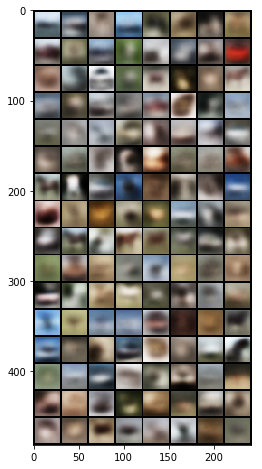

In [33]:
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch)
plot_batch(batch_hat.data)